# Parametric Manipulation PyTorch

In [ ]:
# Importing Libraries
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
from IPython.display import display as dp
import sympy as sym
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Set seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)


## Model Training Function

In [ ]:
def model_trainer(f, n=None, lr=0.01, numepochs=100,
                  domain_size=30, domain_bounds=None, h=8, plot_results = False):
    """
    Train a 1D regression ANN on y = f(x).

    Parameters
    ----------
    - f : callable or sympy expression in x. Target function f(x).
    - n : torch.Tensor or None.
      --> Domain points x (N×1). If None, generated automatically.
    - lr : float Learning rate for SGD.
    - numepochs : int Number of training epochs.
    - domain_size : int number of domain points.
    - domain_bounds : [float, float] or None
        Range [xmin, xmax] when generating x. If None, [-2, 2].
    - h : int number of hidden units.

    Returns
    -------
      x : torch.Tensor
          Domain points (N×1).
      y : torch.Tensor
          True targets f(x) (N×1).
      y_hat : torch.Tensor
          Model predictions (N×1).
      losses : torch.Tensor
          Loss history over epochs.
      ANNreg : nn.Module
            Trained model.
      corr : float
            Correlation between y and y_hat.
    """

    # 1) If f is a data generator: f() -> (x, y)
    if callable(f):
        try:
            sample = f()   # try calling with no args
        except TypeError:
            sample = None

        if isinstance(sample, tuple) and len(sample) == 2:
            # Treat as data generator, e.g. reg_generator
            x, y = sample
            x = x.float()
            y = y.float()
        else:
            # Treat as analytical callable f(x_np) -> y_np
            # Build domain x
            N = domain_size
            if n is None:
                if domain_bounds is None:
                    xmin, xmax = -2.0, 2.0
                else:
                    xmin, xmax = domain_bounds
                x = torch.linspace(xmin, xmax, N).reshape(-1, 1)
            else:
                x = n

            # compute targets y = f(x)
            x_np = x.detach().numpy().reshape(-1)
            y_np = f(x_np)
            y_np = np.asarray(y_np).reshape(-1)
            y = torch.tensor(y_np, dtype=torch.float32).reshape(-1, 1)


    # 2) If f is a SymPy expression
    else:
        # assume SymPy expression in x
        x_sym = sym.symbols('x')
        f_lamb = sym.lambdify(x_sym, f, "numpy")

        N = domain_size
        if n is None:
            if domain_bounds is None:
                xmin, xmax = -2.0, 2.0
            else:
                xmin, xmax = domain_bounds
            x = torch.linspace(xmin, xmax, N).reshape(-1, 1)
        else:
            x = n

        # compute targets y = f(x)
        x_np = x.detach().numpy().reshape(-1)
        y_np = f_lamb(x_np)
        y_np = np.asarray(y_np).reshape(-1)
        y = torch.tensor(y_np, dtype=torch.float32).reshape(-1, 1)


    ## Building the Model:
    ANNreg = nn.Sequential(
        nn.Linear(1, h),   # 1 input -> h hidden
        nn.ReLU(),         # Action function
        nn.Linear(h, 1)    # h hidden -> 1 output
    )

    # Training Setup
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.SGD(ANNreg.parameters(), lr=lr)

    losses = torch.zeros(numepochs)

    # Starting The Training:
    for epochi in range(numepochs):
        preds = ANNreg(x)
        loss = loss_fn(preds, y)
        losses[epochi] = loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Final Predictions
    y_hat = ANNreg(x).detach()
    corr = np.corrcoef(y.T, y_hat.detach().T)[0,1]

    # Avoiding nan correlation values
    if np.isnan(corr):
      corr = 0.0

    # Plotting the results if ture
    if plot_results:
      # Plotting The Loss
      plt.plot(losses.detach(), 'o', markerfacecolor='w', linewidth=.1)
      plt.plot(numepochs - 1, losses[-1].detach(), 'ro')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.title('Final Loss = %g' % losses[-1].item())
      plt.show()

      plt.plot(x, y, 'bo', label = 'Real Data')
      plt.plot(x, y_hat.detach(), 'rs', label = 'predictions')
      plt.legend()
      plt.xlabel('x')
      plt.ylabel('y')
      plt.title(f'prediction-data r={corr:.2f}')
      plt.show()

    return x, y, y_hat, losses, corr, ANNreg

## Regression Function Generator

In [ ]:
def reg_generator(x = None, slope = 1.0, noise = None, domain_size = 30, \
                  regression_lvl = 1.5):

  """
  Generate a linear regression problem to feed the model_trainer function.
  The goal is to test the results for different regression levels and slopes.

  Parameters
  ----------
  - x : torch.Tensor
      Domain points (N×1).
  - slope : float
      Slope of the regression line.
  - noise : random data points (N×1) or None
      Noise of the regression line.
  - domain_size : int
      Number of domain points.
  - regression_lvl : float
      Level of regression.

  """

  # Defining parameters
  N = domain_size
  lv = regression_lvl

  # Assigning required data:
  if x is None:
    x = torch.linspace(-2, 2, N).reshape(-1, 1)
  if noise is None:
    noise = torch.rand(N, 1) * lv

  y = slope * x + noise

  return x, y




## Testing Before Running Embedded Loop

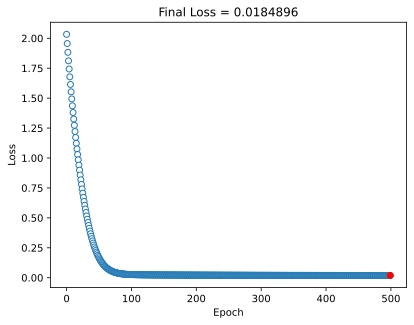

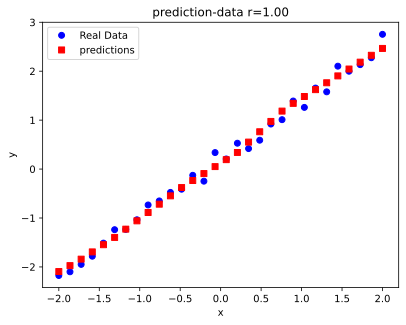

In [ ]:
# Setting the parameters
m = 1.2         # Slope
lv = 0.5        # regression level

# Generating the Function
x, y = reg_generator(slope= m, regression_lvl= lv)

# Passing the regression funtion the generator itself
def my_gen():
    return reg_generator(slope= m, regression_lvl= lv)

x, y, y_hat, losses, corr, model = model_trainer(my_gen, numepochs=500, plot_results=True)

## Different Slopes and Final Loss Comparison

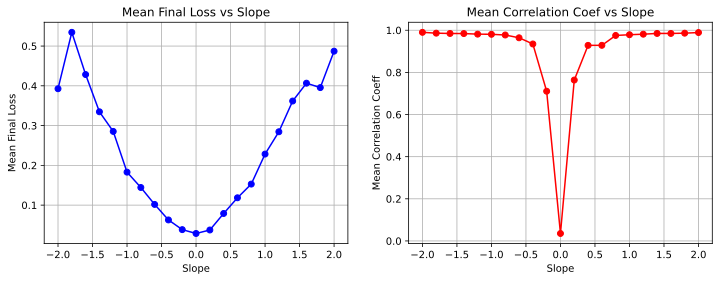

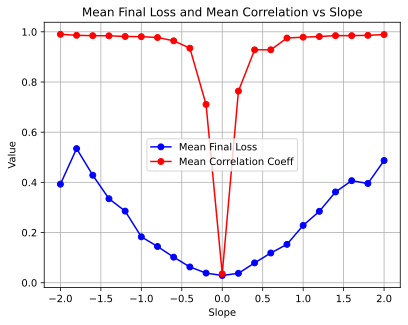

In [ ]:
# Setting testing parameters:

# 50 runs for Slopes sample from -2 to 2 (21 iterations)
runs = 50
iter = 21
slopes = torch.linspace(-2, 2, iter)
lv = 0.5

# Lists to store data:
avg_loss = torch.zeros(iter, 1)
avg_corr = torch.zeros(iter, 1)


for i in range(iter):            # loop over slopes
    m = slopes[i].item()
    loss_runs = torch.zeros(runs)
    corr_runs = torch.zeros(runs)

    for j in range(runs):        # loop over runs for this slope
        def my_gen():
            return reg_generator(slope=m, regression_lvl=lv)

        x, y, y_hat, losses, corr, model = model_trainer(my_gen, numepochs=50)

        loss_runs[j] = losses[-1]
        corr_runs[j] = corr

    # AFTER the inner loop: average over runs for this slope
    avg_loss[i] = loss_runs.mean()
    avg_corr[i] = corr_runs.mean()


# Plotting Results
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(slopes, avg_loss, 'bo-')
ax[0].set_xlabel('Slope')
ax[0].set_ylabel('Mean Final Loss')
ax[0].set_title('Mean Final Loss vs Slope')
ax[0].grid()

ax[1].plot(slopes, avg_corr, 'ro-')
ax[1].set_xlabel('Slope')
ax[1].set_ylabel('Mean Correlation Coeff')
ax[1].set_title('Mean Correlation Coef vs Slope')
ax[1].grid()

plt.show()

# Combined plot
plt.plot(slopes, avg_loss, 'bo-', label='Mean Final Loss')
plt.plot(slopes, avg_corr, 'ro-', label='Mean Correlation Coeff')
plt.xlabel('Slope')
plt.ylabel('Value')
plt.title('Mean Final Loss and Mean Correlation vs Slope')
plt.legend()
plt.grid()



## Observations:

- As |slope| increases, the mean final loss also increases. This is expected because the target values y have larger variance (bigger scale) for larger slopes, and MSE is in absolute units.
- At the same time, the mean correlation between y and y_hat is high for most non‑zero slopes, showing that the model is capturing the linear relationship well despite the higher absolute loss.
- Around slope = 0, the correlation drops toward 0 because y is dominated by noise and carries almost no information about x; in that regime there is essentially no learnable linear structure.
- This illustrates that raw loss values are not directly comparable across different target scales; to compare model quality fairly, either normalize the data or look at scale‑invariant measures like correlation or relative error.